In [1]:
import time
import requests
import io
import image
import hashlib
import os
import selenium
from selenium import webdriver
from PIL import Image
# This is the path I use
# Put the path for your ChromeDriver here
DRIVER_PATH = '/Users/zakijefferson/Downloads/chromedriver'

In [2]:
wd = webdriver.Chrome(executable_path=DRIVER_PATH)
wd.get('https://google.com')  # Navigates to google

In [12]:
# Searching for key word
search_box = wd.find_element_by_css_selector('input.gLFyf')
search_box.send_keys('Dogs')

In [3]:
wd.quit()  # Stops driver

In [2]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))
    
    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [3]:
# def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
#     def scroll_to_end(wd):
#         wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#         time.sleep(sleep_between_interactions)    
    
#     # build the google query
#     search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

#     # load the page
#     wd.get(search_url.format(q=query))

#     image_urls = set()
#     image_count = 0
#     results_start = 0
#     while image_count < max_links_to_fetch:
#         scroll_to_end(wd)

#         # get all image thumbnail results
#         thumbnail_results = wd.find_elements_by_css_selector("img.rg_ic")
#         number_results = len(thumbnail_results)
        
#         print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
#         for img in thumbnail_results[results_start:number_results]:
#             # try to click every thumbnail such that we can get the real image behind it
#             try:
#                 img.click()
#                 time.sleep(sleep_between_interactions)
#             except Exception:
#                 continue

#             # extract image urls    
#             actual_images = wd.find_elements_by_css_selector('img.irc_mi')
#             for actual_image in actual_images:
#                 if actual_image.get_attribute('src'):
#                     image_urls.add(actual_image.get_attribute('src'))

#             image_count = len(image_urls)

#             if len(image_urls) >= max_links_to_fetch:
#                 print(f"Found: {len(image_urls)} image links, done!")
#                 break
#         else:
#             print("Found:", len(image_urls), "image links, looking for more ...")
#             time.sleep(1)
#             load_more_button = wd.find_element_by_css_selector(".ksb")
#             if load_more_button:
#                 wd.execute_script("document.querySelector('.ksb').click();")
        

#         # move the result startpoint further down
#         results_start = len(thumbnail_results)

#     return image_urls

In [4]:
def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)

        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [5]:
def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.2)

    for elem in res:
        try:
            persist_image(target_folder,elem)
        except:
            print("Error with image element")

In [6]:
"""
The function fetch_image_urls expects three input parameters:
query : Search term, like Dog
max_links_to_fetch : Number of links the scraper is supposed to collect
webdriver : instantiated Webdriver
"""

'\nThe function fetch_image_urls expects three input parameters:\nquery : Search term, like Dog\nmax_links_to_fetch : Number of links the scraper is supposed to collect\nwebdriver : instantiated Webdriver\n'

In [51]:
DRIVER_PATH = '/Users/zakijefferson/Downloads/chromedriver'
search_and_download("Assault Rifle", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 101 image links, done!
SUCCESS - saved https://s.abcnews.com/images/US/colt-rifles-mo_hpMain_20190919-152913_16x9_992.jpg - as ./images/assault_rifle/76df607c91.jpg
SUCCESS - saved https://aoav.org.uk/wp-content/uploads/2016/03/INS_M16A4-400x200.png - as ./images/assault_rifle/a96ac78282.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRFfA-gpc5xK0CMvGnGvimuGk66HhnxC_ZXWAhlUEY9GID9UzQ4 - as ./images/assault_rifle/34ba868729.jpg
SUCCESS - saved https://nationalinterest.org/sites/default/files/main_images/W68%20%281%29.jpg - as ./images/assault_rifle/4d787c36c4.jpg
SUCCESS - saved https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Ferikkain%2Ffiles%2F2018%2F09%2Fassault-rifle-suppressed.jpg - as ./images/assault_rifle/e031af7049.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSsw93hU0bgvRwaqh_iqhI-i7Dqy-ld77HLt3fm0iZOwGGixfWU - as ./images/assa

In [54]:
search_and_download("ak guns", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 101 image links, done!
SUCCESS - saved https://i.insider.com/5aec65ff19ee8620008b486f?width=1100&format=jpeg&auto=webp - as ./images/ak_guns/8376963e52.jpg
SUCCESS - saved https://www.wired.com/magazine/wp-content/images/18-11/ff_ak472_f.jpg - as ./images/ak_guns/6a7cb883a9.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR52UtOvWIB-1vrOkPM8L5ugvT17WJTaX2f7qGcCJzRcMQGiL4N - as ./images/ak_guns/ea9c5dae8e.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRylh90IBrg10bnwM4bqkVUI1ETV4iJNDdxqHD_JyXuZEaRn1N5 - as ./images/ak_guns/7d19f14c42.jpg
SUCCESS - saved https://www.dhresource.com/0x0/f2/albu/g10/M00/41/18/rBVaWV3U48yASmcKAAR8VfBcU6A597.jpg - as ./images/ak_guns/fa4e3cbe02.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTJRJWWn5uyCQNCBsJwZreSr6sVZcgHhL-VifAsLuoCQHbmd_B9 - as ./images/ak_guns/744e233317.jpg
SUCCESS - saved https://encrypted-tbn0

In [57]:
search_and_download("military assault rifle", driver_path=DRIVER_PATH, number_images=90)

Found: 100 search results. Extracting links from 0:100
Found: 90 image links, done!
SUCCESS - saved https://ca-times.brightspotcdn.com/dims4/default/070a017/2147483647/strip/true/crop/2048x1152+0+0/resize/840x473!/quality/90/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F64%2F58%2F8d58bce55dc059690a4246f77607%2Fla-1530648920-lkm2z0ulnk-snap-image - as ./images/military_assault_rifle/be5fecc21d.jpg
SUCCESS - saved https://www.veteranstoday.com/wp-content/uploads/2017/08/ScreenHunter_1685-Aug.-31-08.07.jpg - as ./images/military_assault_rifle/d608f12416.jpg
SUCCESS - saved https://upload.wikimedia.org/wikipedia/commons/3/39/PEO_M4_Carbine_RAS_M68_CCO.jpg - as ./images/military_assault_rifle/f422363aa2.jpg
SUCCESS - saved https://cdn.britannica.com/08/130708-004-FA77063E/assault-rifle-M16A1-models-military-M16-Colts.jpg - as ./images/military_assault_rifle/62da64f22f.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQJaLoh5xspX0roh88hiyKQE53rLM

In [59]:
search_and_download("pistols", driver_path=DRIVER_PATH, number_images=200)

Found: 200 search results. Extracting links from 0:200
Found: 200 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQi3fOnqpQ_cOiq3lUQzxYF4GeegvOYH-xv2hj93ssAqMYtaTcj - as ./images/pistols/7ebc786c14.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSimHciITqFYBrrQqhqMsQS_3yBwmllHwsL1ElOFO8Jwi_3cviU - as ./images/pistols/8f016a3802.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSSpxmGiDtLZv2r1ffNcL0j8zX4kxLVNirrTb96V29C9SukrldO - as ./images/pistols/23784111bd.jpg
SUCCESS - saved https://i.ytimg.com/vi/bvTo11dvddU/maxresdefault.jpg - as ./images/pistols/34be6ee77a.jpg
SUCCESS - saved https://www.usacarry.com/wp-content/uploads/2019/01/best-9mm-pistols-2018.jpg - as ./images/pistols/e68f254cf5.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTl2SZEeAeTA0KOZ9U8kJa2NTIeUWMKvVcptQOL5wsc1o2gQAus - as ./images/pistols/3df3a222fc.jpg
SUCCESS - saved https://collectionapi.

In [63]:
search_and_download("Bullpup", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 101 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSC6K8B6HLOb6nbuzYLsqnh2sATMCZkY4hz9QYD_4rINZ6Fz8D9 - as ./images/bullpup/546a29b6d3.jpg
SUCCESS - saved https://nationalinterest.org/sites/default/files/main_images/trhty.png - as ./images/bullpup/4071b89e59.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTwx14JK2BRPD6wFhH2O5Ae5cCG4jk57DhyHXzdbLqeNJE-bSVT - as ./images/bullpup/6fbeaafc3d.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT-eBE2IlnmXUA8jBIMeDvgnXZ-ICsiOQPkEFSH0oBtf0Wtbulp - as ./images/bullpup/3e280b75ab.jpg
SUCCESS - saved https://nationalinterest.org/sites/default/files/main_images/800x450_Screen_Shot_2019-04-30_at_2.13.35_PM_0.png - as ./images/bullpup/2b4f132c4d.jpg
SUCCESS - saved https://cdn.athlonoutdoors.com/wp-content/uploads/sites/8/2019/02/Bulls-543x305.1549425856.jpg - as ./images/bullpup/a7b45460e8.jp

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


SUCCESS - saved https://cz-usa.com/hammer/wp-content/uploads/2019/12/ScorpionBullpupAssembled.png - as ./images/bullpup/59b11711ce.jpg
SUCCESS - saved https://static.wixstatic.com/media/452ad6_10409524414a4e749342bda1fd91965c~mv2_d_2975_2975_s_4_2.jpg/v1/fill/w_2975,h_2975,al_c,q_85/452ad6_10409524414a4e749342bda1fd91965c~mv2_d_2975_2975_s_4_2.jpg - as ./images/bullpup/3115f1cbf8.jpg
SUCCESS - saved https://cdn.improb.com/wp-content/uploads/2019/06/STEYR-ARMS-AUG-A3-M1-223-16-BLK-High-Rail.jpg - as ./images/bullpup/c85c8aa9e3.jpg
SUCCESS - saved https://media.mwstatic.com/product-images/src/primary/888/888872.jpg?imwidth=480 - as ./images/bullpup/a25f8996bb.jpg
SUCCESS - saved https://www.recoilweb.com/wp-content/uploads/2019/08/Bullpup_versus02.jpg - as ./images/bullpup/720ad3bf8a.jpg
SUCCESS - saved https://i.ytimg.com/vi/ZMjrI-55fYw/maxresdefault.jpg - as ./images/bullpup/1495626bf5.jpg
SUCCESS - saved https://www.lockharttactical.com/media/com_hikashop/upload/ranger-shotgun.jpg - a

In [71]:
search_and_download("shooting guns", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 100 image links, done!
SUCCESS - saved https://a57.foxnews.com/media2.foxnews.com/BrightCove/694940094001/2017/10/03/931/524/694940094001_5597002361001_5596953752001-vs.jpg?ve=1&tl=1 - as ./images/shooting_guns/c05191b997.jpg
SUCCESS - saved https://cdn0.wideopenspaces.com/wp-content/uploads/2018/04/ftd-kidsguns-630x339.jpg - as ./images/shooting_guns/21c8d8b12f.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ48WbLhgWgcyeCn5ChrlwWEiTvDnRawWjfle845WUraIadMyi3 - as ./images/shooting_guns/b203f03c22.jpg
SUCCESS - saved https://i.ytimg.com/vi/KDZRmIj_V4k/maxresdefault.jpg - as ./images/shooting_guns/c6d2db2e60.jpg
SUCCESS - saved https://nationalinterest.org/sites/default/files/main_images/trhtyy.jpg - as ./images/shooting_guns/bc3add7419.jpg
SUCCESS - saved https://static.timesofisrael.com/www/uploads/2018/07/DhSHofJXkAIRw0G.jpg - as ./images/shooting_guns/a64acdc7c1.jpg
SUCCESS - saved https://encr

In [74]:
search_and_download("gun use caught on camera", driver_path=DRIVER_PATH, number_images=200)

Found: 200 search results. Extracting links from 0:200
Found: 200 image links, done!
SUCCESS - saved https://cdn.newsapi.com.au/image/v1/2c042357e12f0a93376ecec793f74425?width=650 - as ./images/gun_use_caught_on_camera/eba4c4687c.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSLSFK-jmmRikxx5l7Mwr7JeHcAAkIqXRv26-CD6He_vBiqtRat - as ./images/gun_use_caught_on_camera/2e02ca3d9f.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQvzeLe8F-Cm11oLrqWzyvmqZalEgd72zC6PdZqvMMjJ307Nz6C - as ./images/gun_use_caught_on_camera/d13089b4f1.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSNjULgqAf2vZm8O1JvDU8OZm36_YBpU4J0gwfDH5y04HACwzII - as ./images/gun_use_caught_on_camera/da9c7b777c.jpg
SUCCESS - saved https://i0.wp.com/www.klfy.com/wp-content/uploads/sites/9/2016/07/martin-pkgframe1477_33785757_ver1.0.png?resize=2560%2C1440&ssl=1 - as ./images/gun_use_caught_on_camera/c33088d750.jpg
SUCCESS - saved https://encrypted-

In [81]:
search_and_download("shootings caught on camera", driver_path=DRIVER_PATH, number_images=150)

Found: 100 search results. Extracting links from 0:100
Found: 151 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcStNLyWCrkJj8_0neX0UUTE5ZLKSYE93Q57gnEh9AdabkU6X41z - as ./images/shootings_caught_on_camera/a176324d64.jpg
SUCCESS - saved https://cf-images.us-east-1.prod.boltdns.net/v1/static/4137224153001/6ce040a6-e40b-4cb8-8243-00170b256b96/d821edab-7335-4bc2-a11c-2aa4d48408d0/1280x720/match/image.jpg - as ./images/shootings_caught_on_camera/b71af41243.jpg
SUCCESS - saved https://cdn.abcotvs.com/dip/images/3683607_063018-ewn-10pm-texas-city-shooting-vid.jpg?w=800&r=16%3A9 - as ./images/shootings_caught_on_camera/4041ad2d6a.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQUp4KVgb-QPZAIpBrRlTQraWYMcPh_viAcnVtkGDCzO7tBdxxv - as ./images/shootings_caught_on_camera/559e0778b4.jpg
SUCCESS - saved https://cdn.cnn.com/cnnnext/dam/assets/170629084520-bus-shootout-large-169.jpg - as ./images/shootings_caught_on_camera/a4451a8

In [83]:
search_and_download("guns on people holstered", driver_path=DRIVER_PATH, number_images=150)

Found: 100 search results. Extracting links from 0:100
Found: 150 image links, done!
SUCCESS - saved https://image.shutterstock.com/image-photo/petite-woman-carrying-holstered-gun-600w-98252540.jpg - as ./images/guns_on_people_holstered/00e71561a0.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQvsiZgX4b0eq4CIDkKmthJXWuHG65XMxQfX8tg1nKs4j4axvmW - as ./images/guns_on_people_holstered/956ad00f07.jpg
SUCCESS - saved https://thumbs.nosto.com/quick/magento-a0049d1d/8/1291/48f8db7b481a450784d206342bb2875fa67ccb178e59c7578e98d1773e115f36a/A - as ./images/guns_on_people_holstered/87ff974b3c.jpg
SUCCESS - saved https://media.mwstatic.com/images/finder/steps/holster-finder-step-one-v2-1.jpg - as ./images/guns_on_people_holstered/c5d131af1d.jpg
SUCCESS - saved https://i.ytimg.com/vi/a4bBHoGqD8Y/hqdefault.jpg - as ./images/guns_on_people_holstered/c332e5224c.jpg
SUCCESS - saved https://images-na.ssl-images-amazon.com/images/I/91%2BOkslGrfL._AC_SX425_.jpg - as ./images/g

In [42]:
search_and_download("shooting", driver_path=DRIVER_PATH, number_images=150)

Found: 200 search results. Extracting links from 0:200
Found: 150 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQlpyDQA1KBKVCuBHCjrp_XipFOvfMiICZJWz99Aa6PRuCOlLof - as ./images/shooting/fbcc8d8dd9.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQZomAm0up5LIQcKBIpEjLTDOZWHJCuInrE4tTUB1aW8eZDm9Oo - as ./images/shooting/aa2aeb5fca.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSrTtfeFFAh9lkieqS-SMOAFk87dnrupRvTvS7aV8u179WjIQxp - as ./images/shooting/1f26929034.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTh_PTuM8hvRGpi0XO3_0GSCyOHgDD2B8kCRiNzmMKGLKo14M7N - as ./images/shooting/ad01dbe063.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSCZDh5-Q2vkFMrfHh-E2glEAmJD6a6QiJWHPcsXutns87LA6rq - as ./images/shooting/b8bfdc86e8.jpg
SUCCESS - saved https://gtimg.tokyo2020.org/image/private/t_article-lead-image-desktop/production/zcvczw1ectee

In [44]:
search_and_download("shooting stance", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 100 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTnn5gxLYz4tIgG67oq3C4PjvzK6_O19tV98UyrDRB-RtJ2sk_I - as ./images/shooting_stance/a003777ff5.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTXkj0-WkKruPYvaqp1sqdHP1PlMEqTCgsWtRbn8sMeq2UEzACv - as ./images/shooting_stance/99c438f75b.jpg
SUCCESS - saved https://m8gib5f3d5-flywheel.netdna-ssl.com/wp-content/uploads/2019/05/Center-Axis-Relock-1-608x1024.jpg - as ./images/shooting_stance/70f0faa044.jpg
SUCCESS - saved https://www.gunnuts.net/wp-content/uploads/2013/07/Stance-article-Max-785x1024.jpg - as ./images/shooting_stance/3f631f021a.jpg
SUCCESS - saved https://cdn0.thetruthaboutguns.com/wp-content/uploads/2017/09/Screen-Shot-2017-09-27-at-8.42.11-AM-600x369.png - as ./images/shooting_stance/5cece8d2b8.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQtvXJBHu0xfYQR8WLXp0UFvpPm

In [11]:
search_and_download("john wick gun scenes in movies", driver_path=DRIVER_PATH, number_images=150)

Found: 100 search results. Extracting links from 0:100
Found: 151 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSV_R8RWjCCFkmZphpy3CR5_m_XDlBY9HpOxTe9bQRTee9q61nY - as ./images/john_wick_gun_scenes_in_movies/4f412bcf38.jpg
SUCCESS - saved https://www.maxim.com/.image/t_share/MTY0MTAzNjc4NjQ1NTExOTEx/jackson-spidell-with-keanu.jpg - as ./images/john_wick_gun_scenes_in_movies/a4514ab7ef.jpg
SUCCESS - saved https://www.range365.com/sites/range365.com/files/styles/opengraph_1_91x1/public/images/2018/07/p30l_2.jpg?itok=qdwyxVI4 - as ./images/john_wick_gun_scenes_in_movies/6e8a8734f2.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTB9ZGse9SdK0_lKGBnqh9Nu7QM0Bvux1SBY7nt-vn7mwoUDIK_ - as ./images/john_wick_gun_scenes_in_movies/7ff86546d4.jpg
SUCCESS - saved https://lh3.googleusercontent.com/proxy/A364PXhdKovBrgmxpKxsfAf8lJOM7t215RTlvlMF3g4xa-NjN_HtfKcfnay_Z9AAwEySHvIquT5hd6nCfMy-goQtZYyirdVc0B6Lrhb2d6QCkzaGGbJGTvU4Dym4mbR

In [8]:
search_and_download("gun training", driver_path=DRIVER_PATH, number_images=130)

Found: 100 search results. Extracting links from 0:100
Found: 130 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcROUrARK3xLWvlh5wapLeDVAuDyyVfidg-FhcKfUuQZx_n2F3kV - as ./images/gun_training/708c9c71a9.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRaq_bUryUCYcpYBlm89mXXaIR9EWXbdpMR3OHSjqvIkxVehpVh - as ./images/gun_training/c38d21c6df.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSQrdoztdJhPIwt82VBw8JrTLRrRwIKxuogBSU1-4sVM8B80yFk - as ./images/gun_training/86da8d45e4.jpg
SUCCESS - saved https://img.grouponcdn.com/iam/bVCEX4moidQueEUkkjsX/SC-2048x1229/v1/c700x420.jpg - as ./images/gun_training/41aca7fc8d.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQb1Ne1Xr2-rg4wLsI0cY4TgesELGxklcgftd74s0iHOcr3UG-M - as ./images/gun_training/142d003a5a.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQrNFVA_m1DQCfTJ2p9A3NCFIp_yjiFuRFmLFLUDkHXqO

In [38]:
search_and_download("gun caught on camera", driver_path=DRIVER_PATH, number_images=150)

Found: 200 search results. Extracting links from 0:200
Found: 150 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR8rNd7ybh0hqUu1-7skYZYMsy5MkATPeu0k3zolUi6YNxxEaXw&usqp=CAU - as ./images/gun_caught_on_camera/51b241b763.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTKABVApLuVcjEc4EnQB_Rmb32pG8USlO2efWdwm4OtGHhIYAa5&usqp=CAU - as ./images/gun_caught_on_camera/505f1f44fe.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQNUCUJlVPdPeYO9k9sTJquyjs8Sucm7QPwVtg8rHsi6XRpYOB7&usqp=CAU - as ./images/gun_caught_on_camera/094dd49fb4.jpg
SUCCESS - saved https://www.lawenforcementtoday.com/wp-content/uploads/2019/05/Screen-Shot-2019-05-25-at-1.23.09-PM.png - as ./images/gun_caught_on_camera/212c6b8e94.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSaEAmRnJvvtePRYiSAkkgdtls8lDctvIDmRyGwt40HUdDKmHsb&usqp=CAU - as ./images/gun_caught_on_camera/43e18c0c5f.jpg
SUCCESS - saved h

In [40]:
search_and_download("black hawk down down gun scene", driver_path=DRIVER_PATH, number_images=150)

Found: 100 search results. Extracting links from 0:100
Found: 150 image links, done!
SUCCESS - saved https://i.ytimg.com/vi/e5JYpK1A9Cg/hqdefault.jpg - as ./images/black_hawk_down_down_gun_scene/e228fa099f.jpg
SUCCESS - saved https://www.imfdb.org/images/thumb/2/27/RangersM4.jpg/500px-RangersM4.jpg - as ./images/black_hawk_down_down_gun_scene/c1993ac532.jpg
SUCCESS - saved https://www.imfdb.org/images/thumb/1/1d/BHD_001.jpg/601px-BHD_001.jpg - as ./images/black_hawk_down_down_gun_scene/cb76a6e8b5.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTgGy8XMA8NMViGRBNL0nZnHzQLsIMhL-sZhFE_S2wWwqRJVVEN&usqp=CAU - as ./images/black_hawk_down_down_gun_scene/55b1a02ed0.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRCyR8DQv9x3dAKsnEC1Z7e0Twfq_GIm_IllMMz6Tnzz9gb9id4&usqp=CAU - as ./images/black_hawk_down_down_gun_scene/87297a7caa.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSy6NTQhWIQr86MKRQgFWHd9eKAU4RrZC2VpHEV

In [46]:
search_and_download("modern rifles", driver_path=DRIVER_PATH, number_images=140)

Found: 200 search results. Extracting links from 0:200
Found: 140 image links, done!
ERROR - Could not save https://www.military-today.com/firearms/tavor_tar21.jpg - cannot identify image file <_io.BytesIO object at 0x10b682f90>
SUCCESS - saved https://images-na.ssl-images-amazon.com/images/I/61EHL7FLksL._AC_SX522_.jpg - as ./images/modern_rifles/ffe6ccb7bf.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTYXa-6j91xW-0kfbs-uP8bSNJDQeZnbqwftmkLHoqOeTmCHEj8&usqp=CAU - as ./images/modern_rifles/d633becdae.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQvRvTfDNXCKK1EFlyV5McEHlAAcY_tNCOouYccV0LrV3K6NcHx&usqp=CAU - as ./images/modern_rifles/9dd6146b8d.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRgt8Ybn0L-jXsYmge39DFlspLVrrsBQdxBBC3Fo3PhjPkM4hpA&usqp=CAU - as ./images/modern_rifles/0f9ad7d467.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTOkEbhdgPJtKtvQxZfSfXHk-jzd6hpHk85ECbQ2

In [50]:
search_and_download("modern handguns", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 100 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRQ0GN4_6DdLRf6ZQ3F2PyaLn92sEYCYDJfHfEkYsa-uCEU8C5b&usqp=CAU - as ./images/modern_handguns/2bc7948461.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR0C4OhDvF3nRHF-CGyCXuaKcHyuNLz0wHckHkzRmYn1z01pQQo&usqp=CAU - as ./images/modern_handguns/e8f81943f9.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQF4FOuuUgLYVuAIx0ffMUrUpz4BVKQf1jI8sA25Wk8_rHHixZA&usqp=CAU - as ./images/modern_handguns/cece8d4774.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT0VqGN-7hmp6De914hAaFwyIHht2JJoaZnghrNwSbwwd6SQXRr&usqp=CAU - as ./images/modern_handguns/9d30800571.jpg
SUCCESS - saved https://cdn1.epicgames.com/ue/product/Screenshot/2-1920x1080-617a2461e69b608f1bae19e24d193f3a.jpg - as ./images/modern_handguns/670b021274.jpg
SUCCESS - saved https://gunmagwarehouse.com/medi

In [53]:
search_and_download("handgun stance", driver_path=DRIVER_PATH, number_images=100)

Found: 200 search results. Extracting links from 0:200
Found: 100 image links, done!
SUCCESS - saved https://www.trainwithsafe.com/wp-content/uploads/2016/07/12717359_562151443939743_1665096773766632567_n.jpg - as ./images/handgun_stance/7f15f50196.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-CqEUp48ce1DqGpEya9mWFi1E_bAqYPJQeSCR7RIlsjwB9pl8&usqp=CAU - as ./images/handgun_stance/23413ede93.jpg
SUCCESS - saved https://i.pinimg.com/originals/cc/8e/98/cc8e9837aea6d74da43ee65eaff8281b.jpg - as ./images/handgun_stance/728653fee7.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSyKaAfbjsUK5BesPwjA9G22jDohHdrLu5hXohekvg3TwE3s1wJ&usqp=CAU - as ./images/handgun_stance/eb4bb6f8e8.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSGD3cKfgQvri2c5eoUtUxluP7GWkYPAA3dbwalWJoUorxjcWnP&usqp=CAU - as ./images/handgun_stance/ae1b1cdcdc.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTDfKKVD68g

In [55]:
search_and_download("rifle stance", driver_path=DRIVER_PATH, number_images=100)

Found: 200 search results. Extracting links from 0:200
Found: 101 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSfW9NBfcQKcCn5TVtjWvwpRluZaH_amYoDpt1-HhxanV8I7-dG&usqp=CAU - as ./images/rifle_stance/2a3457d1f4.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRjablQLUoeMZEuKppnbQaWZDXgGahe0pawuTWrKZyqtir72V9t&usqp=CAU - as ./images/rifle_stance/5923cd2031.jpg
SUCCESS - saved https://external-preview.redd.it/R7n8FNB9ARaKpj_jBaPXSJjwkBdqJHxrbJM6HPhB6CM.png?auto=webp&s=c744272dbfb797ec00cc7d52b7a1f02e5cea6c90 - as ./images/rifle_stance/c592ff7e51.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSNYtTseCklu2f3DtPH-0XC-Be3i3YsPMoprS8Nh84FEGKWONvN&usqp=CAU - as ./images/rifle_stance/f410039eee.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSC1fIsW6rJMn6qasveVjeHxnjBM6eQCFnhCRpjTDvxWGIry7UH&usqp=CAU - as ./images/rifle_stance/bd2d2c4754.jpg
SUCCESS - saved https://enc

In [7]:
search_and_download("call of duty gun scenes", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 100 image links, done!
SUCCESS - saved https://cdn.vox-cdn.com/thumbor/n94lj0gdWcCgvuX0iHC6N84DLp8=/1400x0/filters:no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/19329940/call_of_duty_modern_warfare_2.png - as ./images/call_of_duty_gun_scenes/95a527d271.jpg
SUCCESS - saved https://i.ytimg.com/vi/rC2-YZT9X5k/maxresdefault.jpg - as ./images/call_of_duty_gun_scenes/c5de597502.jpg
SUCCESS - saved https://freegametips.com/wp-content/uploads/2019/11/Call-of-Duty-Modern-Warfare-corrects-flickering-in-PC-video-1024x576.jpg - as ./images/call_of_duty_gun_scenes/2ddcc1932f.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTaPU8TxU0UX_BWEV3nD443OPXE525wc4aYLqo8Ez2q4EEmYTKt&usqp=CAU - as ./images/call_of_duty_gun_scenes/88839c0a2a.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSCzD8swvU8n3TxwD-QLWVyzU1gGMDen9MRifTWz93bu7Wkdncz&usqp=CAU - as ./images/call_of_duty_gun_scenes/d

In [7]:
search_and_download("people pointing fingers", driver_path=DRIVER_PATH, number_images=120)

Found: 100 search results. Extracting links from 0:100
Found: 120 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRCqup7YJEOEdSFdx7s4oXSEjBjk1o9i5x3n7duZwFbW-PxwMs8&usqp=CAU - as ./images/people_pointing_fingers/cff172da33.jpg
SUCCESS - saved https://previews.agefotostock.com/previewimage/medibigoff/7325ced46f274e9ae789d1f0dddd2ed7/esy-000271321.jpg - as ./images/people_pointing_fingers/5f28f4e7e3.jpg
SUCCESS - saved https://previews.agefotostock.com/previewimage/medibigoff/5e49feb617fde25cd1c97c9b41c860d8/esy-006192988.jpg - as ./images/people_pointing_fingers/ff07e01c67.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTODZZU1QahmfaFQmXCFZ_q3d5EICVeliD_a7sC-iHWXl0m6qcd&usqp=CAU - as ./images/people_pointing_fingers/af6e713d07.jpg
SUCCESS - saved https://res.cloudinary.com/fleetnation/image/private/c_fit,w_1120/g_south,l_text:style_gothic2:%C2%A9%20Tetra%20Images,o_20,y_10/g_center,l_watermark4,o_25,y_50/v1515736821/

In [9]:
search_and_download("people pointing finger gun", driver_path=DRIVER_PATH, number_images=120)

Found: 200 search results. Extracting links from 0:200
Found: 120 image links, done!
SUCCESS - saved https://cmkt-image-prd.freetls.fastly.net/0.1.0/ps/6200045/910/683/m2/fpnw/wm1/fjqxuxznz76yfsukd5cvwpiufvprr5emyawnjytrs3jkeogq7gjprsmszcfgxxfh-.jpg?1554394768&s=4583276e4e2d701752efe1df023926d2 - as ./images/people_pointing_finger_gun/d057f7a1a2.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR54vyJ_9Aa-nksas5pgmTph4rM273lZnrr1Dyn6ZsWYcgnnOmq&usqp=CAU - as ./images/people_pointing_finger_gun/22241c3d49.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSu3cmd0Ep36pmTTcIuD2xW2tBc1rB5gLj7BCpRIlzj_v1lwO-_&usqp=CAU - as ./images/people_pointing_finger_gun/b17b7c0019.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTiqm2NnfNrMplvbSCaMUyuw6dmQKbtp6cgB8l-NxfxRk64Hfw0&usqp=CAU - as ./images/people_pointing_finger_gun/02ab2c48c9.jpg
SUCCESS - saved https://cdn0.thetruthaboutguns.com/wp-content/uploads/2019/10/finger

In [11]:
search_and_download("finger gun", driver_path=DRIVER_PATH, number_images=120)

Found: 200 search results. Extracting links from 0:200
Found: 121 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQm2l-FTgDOyxPCHwN1kmZhSaPCPjsBvd7bLI28n3tfR5D0ZUtA&usqp=CAU - as ./images/finger_gun/5c3696c0a5.jpg
SUCCESS - saved https://image.shutterstock.com/image-photo/hand-gun-260nw-52049605.jpg - as ./images/finger_gun/e9afb3bb2e.jpg
SUCCESS - saved https://d97yz4wvpgciz.cloudfront.net/remote.axd?https://d3uwh8jpzww49g.cloudfront.net/sharedmedia/1507395/screen-shot-2015-03-14-at-85612-pm.png?preset=article - as ./images/finger_gun/28269639fc.jpg
SUCCESS - saved https://imageproxy.themaven.net/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fmaven-user-photos%2Fbluelivesmatter%2Finternal%2F38OeeK-u10KwXqS4-B3liw%2FWbq66FL6p0i-smSycQCkqA - as ./images/finger_gun/ba288fe9bf.jpg
SUCCESS - saved https://cdn0.thetruthaboutguns.com/wp-content/uploads/2019/10/finger-gun-gesture-point.jpg - as ./images/finger_gun/a509f4a97d.jpg
SUCCESS - saved https://e

In [13]:
search_and_download("people standing", driver_path=DRIVER_PATH, number_images=120)

Found: 100 search results. Extracting links from 0:100
Found: 120 image links, done!
SUCCESS - saved https://media.istockphoto.com/photos/rear-view-of-creative-people-standing-in-row-picture-id585798196 - as ./images/people_standing/09e2b5d6d9.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQa4vPfC_3AnD-6oAt0R-NJ6msSXxO9lP_wiYI9lJZXa_XuxDIk&usqp=CAU - as ./images/people_standing/1183c41f5b.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTSAJxHDfllbguI9_RbPHbNmTN8SzB5VlxlOKMuw7b1QLtfCeiT&usqp=CAU - as ./images/people_standing/0eccd8b88d.jpg
SUCCESS - saved https://p1.hiclipart.com/preview/796/55/708/yo-soy-franky-people-standing-side-by-side-png-clipart.jpg - as ./images/people_standing/95f31ac4e7.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS0SeD0pB68YehzEZWJnUxTZoODLHRkC_EvvNHNn_UDQoiJCnqj&usqp=CAU - as ./images/people_standing/0e5d2a6c8a.jpg
ERROR - Could not save https://www.publicdomainpictures.n

In [15]:
search_and_download("people running", driver_path=DRIVER_PATH, number_images=120)

Found: 100 search results. Extracting links from 0:100
Found: 121 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS7OCB-kI6LSi75xGBT9bpJlRd3cVc5TMOIJafAEC3cn-KA8bnV&usqp=CAU - as ./images/people_running/ecacb7ff33.jpg
SUCCESS - saved https://thumbs.dreamstime.com/b/fitness-people-running-blue-lines-cartoon-isolated-vector-illustration-graphic-design-145354072.jpg - as ./images/people_running/48009235ab.jpg
SUCCESS - saved https://i.ytimg.com/vi/QjCEZfsKBwE/maxresdefault.jpg - as ./images/people_running/a491d75571.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTyDpRsivddHV7v3dLyaAFIW7QywSBxMgjxCLhRel7xdsdznLKs&usqp=CAU - as ./images/people_running/ad71ca06a4.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTuNvPiMEQkKfHdlsB_7vgV7LPvLO4ZNeQOgNwglWAdoFz9xzIH&usqp=CAU - as ./images/people_running/bdee72801b.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcThcOQueapu

In [19]:
search_and_download("people jumping", driver_path=DRIVER_PATH, number_images=100)

Found: 100 search results. Extracting links from 0:100
Found: 100 image links, done!
SUCCESS - saved https://cdn2.vectorstock.com/i/1000x1000/53/06/happy-jumping-people-vector-22665306.jpg - as ./images/people_jumping/8db8458c4b.jpg
SUCCESS - saved https://thumbs.dreamstime.com/z/happy-people-jumping-2385743.jpg - as ./images/people_jumping/a7f0139210.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRQJ3hf5AhKVatDM_wmSQhAYO_hirGpD3FVTWioZEB6JNQMyjoc&usqp=CAU - as ./images/people_jumping/66a85ad3a7.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSuRuAtmXumBhCPJWXG5XN-P54Qmb5-36yf1Ssk5FUjg5RJ6ipw&usqp=CAU - as ./images/people_jumping/05681a62d0.jpg
SUCCESS - saved https://lenejyttehansen.files.wordpress.com/2016/08/happy-people-jumping-into-air.jpg - as ./images/people_jumping/41aad2efd2.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRlFyXZjppn78NtFlu1eagSLCptgomTEvwHwn70F0ZqmiQQjOkP&usqp=CAU - as ./image

In [21]:
search_and_download("people with their hands up", driver_path=DRIVER_PATH, number_images=120)

Found: 200 search results. Extracting links from 0:200
Found: 121 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQjXrHb4NQi_h3MjHhMZclW4D6TfIekSvw6WcOJP53UZjwSH_Be&usqp=CAU - as ./images/people_with_their_hands_up/e9df904b4a.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTa7yPz-qkbCQgSYMXzM_gB2KZjwGaTA7OvIxmkNkIMFuvl2dw_&usqp=CAU - as ./images/people_with_their_hands_up/e614f4d58c.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQXzQIjjguvWGj3GHReI0VY6791eAmHvygik6fM8HInPg0hKYnf&usqp=CAU - as ./images/people_with_their_hands_up/cb7629d109.jpg
SUCCESS - saved https://previews.123rf.com/images/lacheev/lacheev1906/lacheev190600067/124898903-a-group-of-happy-young-people-raised-their-hands-up-at-sunset-on-the-nature-friends-in-the-evening-i.jpg - as ./images/people_with_their_hands_up/05e129b04b.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRUZad1EOab4tqas1cGG02

In [23]:
search_and_download("people on the street", driver_path=DRIVER_PATH, number_images=120)

Found: 200 search results. Extracting links from 0:200
Found: 120 image links, done!
SUCCESS - saved https://media.realitatea.net/multimedia/image/201811/full/proteste_budapesta_29133300.jpg - as ./images/people_on_the_street/b1214d2272.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS5owRUPQKdCuCjvzITQANN5b-sazPxb_So6KD7czdW7nxUCj40&usqp=CAU - as ./images/people_on_the_street/fb4cafe448.jpg
SUCCESS - saved https://live.staticflickr.com/890/26487466477_76fd982230_b.jpg - as ./images/people_on_the_street/d9fb605b87.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSoNVi83d2Nfz9LPR7cNuaB1DX_WN9qJs7kCzgFVblqPvwlRSJz&usqp=CAU - as ./images/people_on_the_street/6e1476aefc.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTRvhG3MR_0rGUOqNcymTORuqjWqrPiF2MBM_oxzbXkIW_AOxjs&usqp=CAU - as ./images/people_on_the_street/7843d13c33.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSFLqEaVVInSb

Found: 100 search results. Extracting links from 0:100
Found: 120 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSUK0qjmpmQqC7lYAD_Vb10Vf8K--BXAjsDpqfNzMq_ZtQuO-S0&usqp=CAU - as ./images/walking_on_the_street/2db01b9211.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTHNB-MPUhq2brMJBsTTm5sMNlRYp2Tvdy3Aoa8-KJMDICoYspa&usqp=CAU - as ./images/walking_on_the_street/90a234c598.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQrQuQmXqzuBXl3fq1Fn6vmdm-DvoshtaLGff6vAIr0axgMo6nu&usqp=CAU - as ./images/walking_on_the_street/e92676548b.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRQjV-yuK7sn1qUwmtzu6_hrjxkE6viBu9mG1G5qOMzJPqfWewH&usqp=CAU - as ./images/walking_on_the_street/1e8c5c22f5.jpg
SUCCESS - saved https://thumbs.dreamstime.com/z/girl-walking-street-city-wearing-skirt-back-beautiful-young-historic-center-rome-italy-driveway-paving-62260101.jpg - as ./images/walki
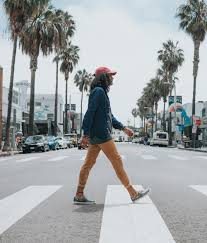
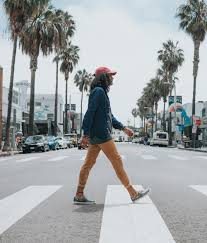
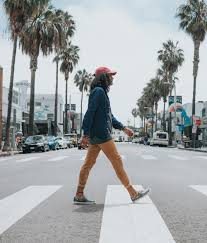

In [26]:
search_and_download("walking on the street", driver_path=DRIVER_PATH, number_images=120)

In [28]:
search_and_download("on phones", driver_path=DRIVER_PATH, number_images=100)

Found: 200 search results. Extracting links from 0:200
Found: 101 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTqpyJbHULAFnAg_T3v-YYJL_lciIRDmr5T8SugBSAvwzixfyad&usqp=CAU - as ./images/on_phones/92b54fe3dd.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSCiVYZ-zfOtjMOOH8-jfCW353awz-PpUZuKniJbBUeay7utlPu&usqp=CAU - as ./images/on_phones/c0bec9d727.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRI1nYkuLQr-9N88Ied8letkNoMxLfy4CFfGqAJ9m7YnQEDy8Xw&usqp=CAU - as ./images/on_phones/79716310d4.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRqTqlXaJNWhjTEG5doBfj-dWLhSa9Y3jchiI5mVMxsSg88HDT4&usqp=CAU - as ./images/on_phones/d09a69a96a.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR7khPj6IQCXylPphyWHNoRtz4ivvtdC0uj2K0LJtP8yckM3hNW&usqp=CAU - as ./images/on_phones/13ce4b732a.jpg
SUCCESS - saved https://www.tailit.com/wp-content/uploads/20